# Prometne nesreče v Sloveniji #

## Uvod
Za seminarsko nalogo bom analiziral podatke o prometnih nesrečah v Sloveniji za leti 2019 in 2020. Podatke sem pridobil
iz spletne strani policija.si (https://www.policija.si/o-slovenski-policiji/statistika/prometna-varnost). Isti podatki so tudi dostopni
na spletni strani podatki.gov.si (https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje), vendar manjkajo podatki za leto 2020.


## Cilji
  * Analiza in vizualizacija podatkov.
  * Odgovoriti na vnaprej postavljena vprašanja in na morebitna vprašanja, ki se pojavijo ob reševanju problema.
  * Napovedovanje vrednosti alkohola v krvi na podlagi okoliščin nesreče.
  
  
  ### Vprašanja
  * Kateri vozniki povzročajo največ nesreč?
  * Kakšne okoliščine povzročajo največ nesreč?
  * Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?
  

## Branje podatkov ##

In [1]:
#knjužnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta, date
import scipy.cluster.hierarchy as sch
import scipy
from scipy.stats import multivariate_normal as mvn 

In [2]:
data20 = pd.read_csv("Data/pn2020.csv", ";", encoding="cp1252", decimal=",")
data19 = pd.read_csv("Data/pn2019.csv", ";", encoding="cp1252", decimal=",")

## Priprava podatkov ##

Vse vrsice z mankajočimi vrednostmi odstranimo iz podatkov.

In [3]:
data20 = data20.dropna()
data19 = data19.dropna()

Združimo polji vrednost alkotesta in vrednost strokovnega pregleda. Enote je potrebno vskladiti

In [4]:
# 4 nivoji
alc = []
for a, b in zip(data20["VrednostAlkotesta"], data20["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data20["stopnjaAlkohola"] = alc

alc = []
for a, b in zip(data19["VrednostAlkotesta"], data19["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data19["stopnjaAlkohola"] = alc

Spremenimo tip datuma v datetime.

In [5]:
dateFormat19 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data19["DatumPN"]])
dateFormat20 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data20["DatumPN"]])

In [6]:
data19["datetime"] = dateFormat19
data20["datetime"] = dateFormat20

V nadaljevanju bomo obe mnoožici obdelovali kot eno.

In [7]:
data = pd.concat([data19,data20])

In [8]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
delta = timedelta(days=1)
velikosti = []

while start_date <= end_date:
    velikosti.append(len(dateFormat19[dateFormat19 == start_date]))
    start_date += delta

In [9]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
velikosti2 = []

while start_date <= end_date:
    velikosti2.append(len(dateFormat20[dateFormat20 == start_date]))
    start_date += delta

Sprememba tima ure

In [10]:
data["UraPN"] = [float(x) for x in data["UraPN"]]

## Analiza ##

### Primerjava let ###

(array([1958., 1648., 1811.,  686.,  845., 1509., 1761., 1883., 1778.,
        1921., 1981., 1903., 1163., 1017., 1076.]),
 array([18262.        , 18286.33333333, 18310.66666667, 18335.        ,
        18359.33333333, 18383.66666667, 18408.        , 18432.33333333,
        18456.66666667, 18481.        , 18505.33333333, 18529.66666667,
        18554.        , 18578.33333333, 18602.66666667, 18627.        ]),
 <BarContainer object of 15 artists>)

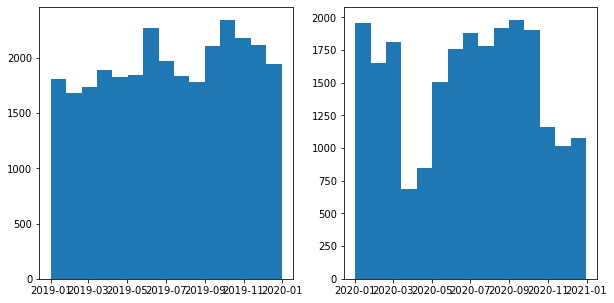

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(dateFormat19, bins=15)
axes[1].hist(dateFormat20, bins=15)

(array([18., 40., 59., 55., 60., 58., 48., 22.,  3.,  3.]),
 array([  6. ,  19.6,  33.2,  46.8,  60.4,  74. ,  87.6, 101.2, 114.8,
        128.4, 142. ]),
 <BarContainer object of 10 artists>)

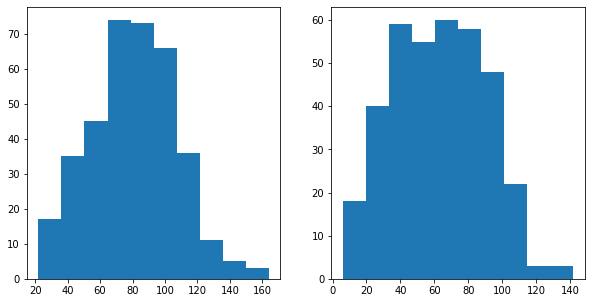

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(velikosti)
axes[1].hist(velikosti2)

### Nad 95% ###

In [13]:
sVelikosti = velikosti + velikosti2

In [14]:
n = len(sVelikosti)
mu = np.mean(sVelikosti)
sigma2 = (n-1)/n * np.var(sVelikosti)

In [15]:
xr = np.linspace(0, 190, 1000)
p_value = 0.95
width = xr[1] - xr[0] 
for qx in xr:
    ltx = xr[xr <= qx]
    P_ltx = [mvn.pdf(x, mu, sigma2) * width for x in ltx] 
    p_value2 = np.sum(P_ltx)
    if p_value <= p_value2:
        print("----")
        print(qx)
        print(p_value2)
        print("----")
        break
    

----
119.43943943943943
0.9504625737490521
----


In [16]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
datumi = []

while start_date <= end_date:
    datumi.append(start_date)
    start_date += delta

In [17]:
sVelikosti = np.array(sVelikosti)
datumi = np.array(datumi)

In [18]:
datumiNad5 = datumi[sVelikosti >= 119]
vrsticeNad5 = data[data["datetime"] == datumiNad5[0]]
for datum in datumiNad5[1:]:
    trenutni = data[data["datetime"] == datum]
    vrsticeNad5 = pd.concat([vrsticeNad5, trenutni])

In [19]:
#vrsticeNad5

### Vozniki ###

(array([  411.,  2757.,  9510., 10522., 10061.,  9171.,  5575.,  3115.,
         1114.,    59.]),
 array([ -1. ,   9.2,  19.4,  29.6,  39.8,  50. ,  60.2,  70.4,  80.6,
         90.8, 101. ]),
 <BarContainer object of 10 artists>)

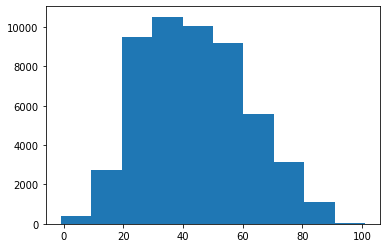

In [20]:
plt.hist(data["Starost"])

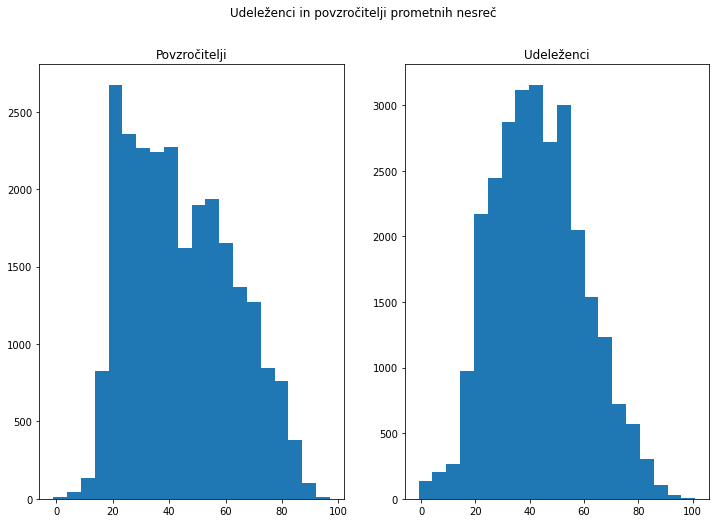

In [22]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Udeleženci in povzročitelji prometnih nesreč')
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0].hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["Starost"], bins=20)
axs[0].title.set_text("Povzročitelji")
axs[1].hist(data[data["Povzrocitelj"] == "UDELEŽENEC"]["Starost"], bins=20)
axs[1].title.set_text("Udeleženci")

Graf udeležencev se porazdeljuje dokaj normalno. Graf povzročiteljev pa nekoliko drugače. Največ nesreč povzroča predvsem mladih ljudi (okoli 20 let). Kar nakazuje na njihovo neizkušenost v prometu. Z višjo starostjo pa ta številka pada.

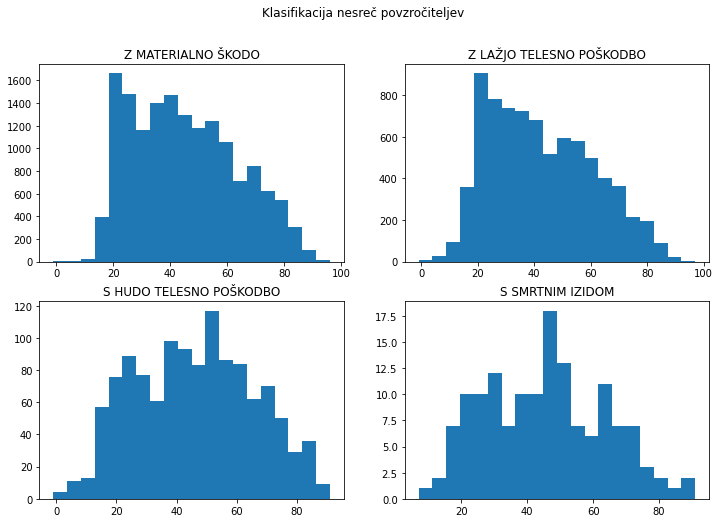

In [23]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Klasifikacija nesreč povzročiteljev')
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z MATERIALNO ŠKODO")]["Starost"], bins=20)
axs[0,0].title.set_text("Z MATERIALNO ŠKODO")
axs[0,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z LAŽJO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[0, 1].title.set_text("Z LAŽJO TELESNO POŠKODBO")
axs[1,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[1,0].title.set_text("S HUDO TELESNO POŠKODBO")
axs[1,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]["Starost"], bins=20)
axs[1,1].title.set_text("S SMRTNIM IZIDOM")

Iz grafov lahko razberemo, da največ nesreč z materialno škodo in z lažjo telesno poškodbo povzročajo predvsem mladi vozniki (okoli 20). Kar se ujema s prejšnim grafom. Medtem pa za nesreče s hudo telesno poškodbo in s smrtnim izidom to nevelja. Največ takih nesreč povzročaj vozniki zrelih let (okoli 50 let). Kar nakazuje na morebitno precenjevanje lastnih sposobnosti.

(array([8660., 3327., 3215., 3171., 1980., 1904., 1556.,  698.,  154.,
           9.]),
 array([ 0. ,  7.3, 14.6, 21.9, 29.2, 36.5, 43.8, 51.1, 58.4, 65.7, 73. ]),
 <BarContainer object of 10 artists>)

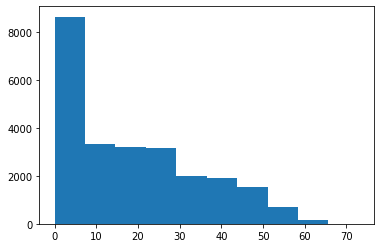

In [24]:
plt.hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["VozniskiStazVLetih"])

Graf prikazuje porazdelitev vozniškega staža v lethi in potrjuje prejsnje ugotovitve, da največ nesreč povzročajo neizkušeni vozniki.

(array([  76.,    0.,    0., 2877.,    0.,    0., 1815.,    0.,    0.,
         483.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

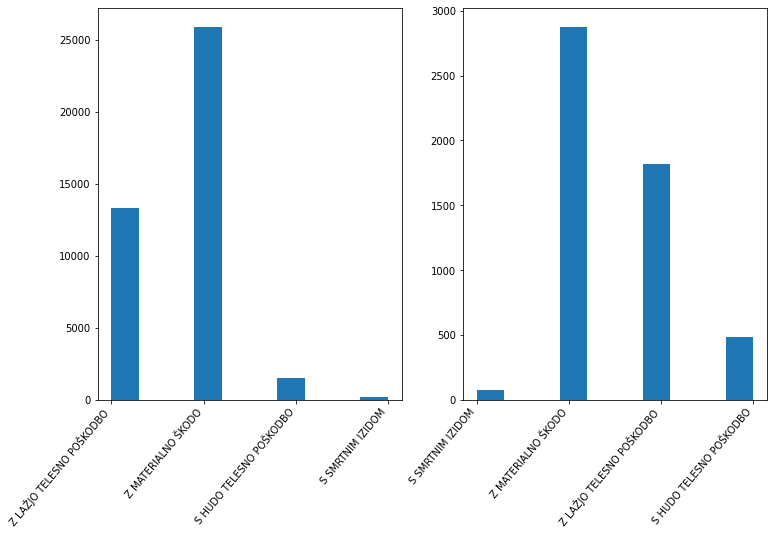

In [25]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["UporabaVarnostnegaPasu"] == "DA"]["KlasifikacijaNesrece"])

axs[1].hist(data[data["UporabaVarnostnegaPasu"] == "NE" ]["KlasifikacijaNesrece"])

In [26]:
(len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]))/ len(data[data["UporabaVarnostnegaPasu"] == "DA"])

0.042141007475448286

In [27]:
(len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["UporabaVarnostnegaPasu"] == "NE"])

0.10645591315939822

Ali uporaba varnostnega pasu vpliva na klasifikacijo nesreče? Da, uporaba varnostnega pasu kar razpolovi verjetnost ,da je pri nesreči smrtni izid ali izid s hudo telesno poškodbo.

### Okoliščine nesreče

In [49]:
import scipy.cluster.hierarchy as sch

In [34]:
data.columns

Index(['ZaporednaStevilkaPN', 'KlasifikacijaNesrece', 'UpravnaEnotaStoritve',
       'DatumPN', 'UraPN', 'VNaselju', 'Lokacija', 'VrstaCesteNaselja',
       'SifraCesteNaselja', 'TekstCesteNaselja', 'SifraOdsekaUlice',
       'TekstOdsekaUlice', 'StacionazaDogodka', 'OpisKraja', 'VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'GeoKoordinataX', 'GeoKoordinataY',
       'ZaporednaStevilkaOsebeVPN', 'Povzrocitelj', 'Starost', 'Spol',
       'UEStalnegaPrebivalisca', 'Drzavljanstvo', 'PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih', 'VrednostAlkotesta',
       'VrednostStrokovnegaPregleda', 'stopnjaAlkohola', 'datetime'],
      dtype='object')

Priprava za hierarhično gručenje

In [51]:
"""grucenje = data[['KlasifikacijaNesrece', 'UraPN', 'VNaselju', 'Lokacija', 'VrstaCesteNaselja','VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'Povzrocitelj', 'Starost', 'Spol','PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih','stopnjaAlkohola', 'datetime']]"""

In [54]:
#L = sch.linkage(grucenje, method="average", metric="jaccard")

# Mogoce izpusti

(array([5035.,    0.,    0., 8601.,    0.,    0.,  201.,    0.,    0.,
         774.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

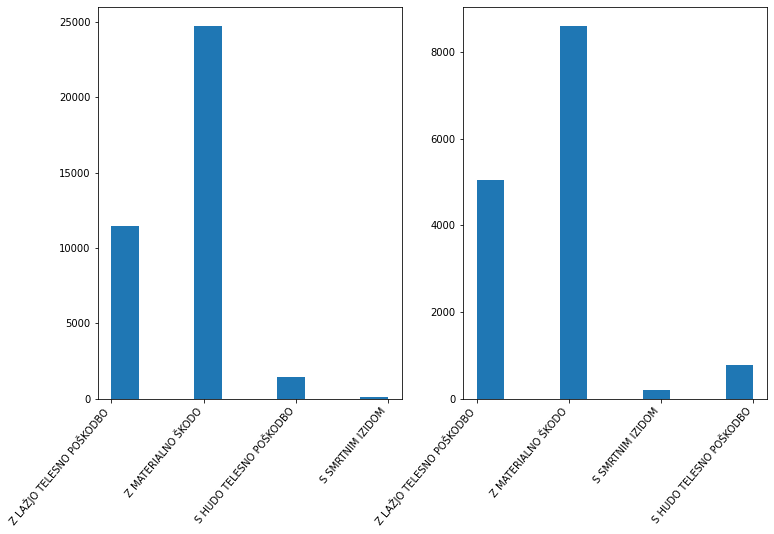

In [48]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["VNaselju"] == "DA"]["KlasifikacijaNesrece"])
axs[1].hist(data[data["VNaselju"] == "NE"]["KlasifikacijaNesrece"])

### Vpliv alkohola

(array([49629.,     0.,     0.,     0.,     0.,     0.,   489.,     0.,
            0.,     0.,     0.,     0.,     0.,   833.,     0.,     0.,
            0.,     0.,     0.,  1344.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

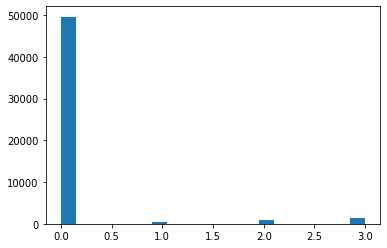

In [29]:
plt.hist(data["stopnjaAlkohola"], bins=20)

(array([1554.,    0.,    0.,   56.,    0.,    0.,  805.,    0.,    0.,
         251.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

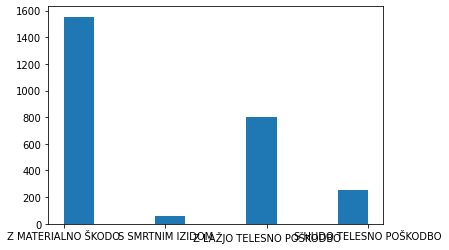

In [30]:
plt.hist(data[data["stopnjaAlkohola"] > 0]["KlasifikacijaNesrece"])

In [31]:
#plt.hist(data20["DatumPN"])

In [32]:
#datetime.strptime(data19["DatumPN"][0], "%d.%m.%Y")

In [33]:
#plt.plot(data19["DatumPN"])